# Using polynomial and step function regression to predict `wage` using `age` in `Wage` dataset

## Preparing the data

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import seaborn as sns; sns.set()

wage = pd.read_csv("../../datasets/Wage.csv")
wage.head()

,Unnamed: 0,year,age,maritl,race,education,region,jobclass,health,health_ins,logwage,wage
0,231655,2006,18,1. Never Married,1. White,1. < HS Grad,2. Middle Atlantic,1. Industrial,1. <=Good,2. No,4.318063,75.043154
1,86582,2004,24,1. Never Married,1. White,4. College Grad,2. Middle Atlantic,2. Information,2. >=Very Good,2. No,4.255273,70.476020
2,161300,2003,45,2. Married,1. White,3. Some College,2. Middle Atlantic,1. Industrial,1. <=Good,1. Yes,4.875061,130.982177
3,155159,2003,43,2. Married,3. Asian,4. College Grad,2. Middle Atlantic,2. Information,2. >=Very Good,1. Yes,5.041393,154.685293
4,11443,2005,50,4. Divorced,1. White,2. HS Grad,2. Middle Atlantic,2. Information,1. <=Good,1. Yes,4.318063,75.043154


In [2]:
wage.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Data columns (total 12 columns):
Unnamed: 0    3000 non-null int64
year          3000 non-null int64
age           3000 non-null int64
maritl        3000 non-null object
race          3000 non-null object
education     3000 non-null object
region        3000 non-null object
jobclass      3000 non-null object
health        3000 non-null object
health_ins    3000 non-null object
logwage       3000 non-null float64
wage          3000 non-null float64
dtypes: float64(2), int64(3), object(7)
memory usage: 281.3+ KB


## a. Predict `wage` with `age` using polynomial regression with L2 penalty.

See [sklearn docs on polynomial regression](https://scikit-learn.org/stable/modules/linear_model.html#polynomial-regression-extending-linear-models-with-basis-functions). We're going to add an L2 penalty for fun (and performance improvement)

In [3]:
from sklearn.preprocessing import PolynomialFeatures, scale
from sklearn.linear_model import Ridge
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

steps = [('poly', PolynomialFeatures()), ('ridge', Ridge())]
pipe = Pipeline(steps=steps)
param_grid = dict(poly__degree=np.arange(1, 5), ridge__alpha=np.logspace(-4, 4, 5))
search = GridSearchCV(pipe, param_grid, cv=10, scoring='neg_mean_squared_error')

In [57]:
%%capture

X, y = wage['age'], wage['wage']
X_sc, y_sc = scale(wage['age']), scale(wage['wage'])
search.fit(X_sc.reshape(-1, 1), y_sc)

The best 10-fold CV model has parameters

In [5]:
search.best_params_

{'poly__degree': 4, 'ridge__alpha': 1.0}

This model has a CV mse test error estimate of

In [62]:
-search.best_score_

0.9156879981745668

This represents an absolute error of

In [63]:
np.sqrt(-search.best_score_)

0.9569158783166715

Not terribly good - this is about one standard deviation (since the data were normalized)

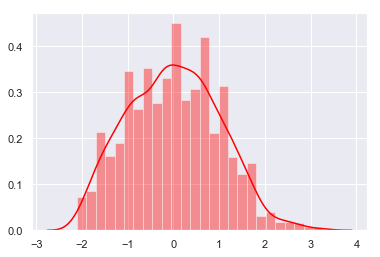

In [70]:
sns.distplot(X_sc, color='red')

Now to use these parameters on the original data to get a real mse test reading

In [65]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

X_poly = PolynomialFeatures(degree=4).fit_transform(X.values.reshape(-1,1))
X_train, X_test, y_train, y_test = train_test_split(X_poly, y, test_size=0.33, random_state=42)
ridge = Ridge(alpha=1).fit(X_train, y_train)
np.sqrt(mean_squared_error(y_test, ridge.predict(X_test)))

/Users/home/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=2.01369e-17): result may not be accurate.
  overwrite_a=True).T


39.239871740545624

We'll plot the model fitted curve against the original data

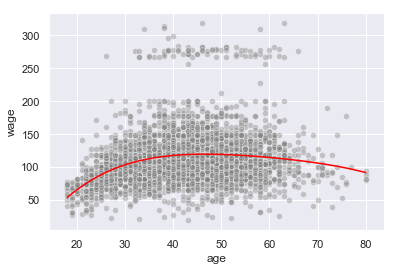

In [61]:
t = np.linspace(X.min(), X.max(), 3000)
y_pred = ridge.predict(PolynomialFeatures(degree=4).fit_transform(t.reshape(-1,1)))

sns.lineplot(t, y_pred, color='red')
sns.scatterplot(X, y, color='grey', alpha=0.4)

## b. Predict `wage` with `age` using step function regression

Sklearn doesn't have a builtin for step functions, so we'll use [`basis-expansions`](http://www.science.smith.edu/~jcrouser/SDS293/labs/lab12-py.html), a Python module by [Matthew Drury](https://github.com/madrury) (cf his [blog post](http://madrury.github.io/jekyll/update/statistics/2017/08/04/basis-expansions.html) for an accessible discussion of basis expansions).

In [12]:
from basis_expansions import Binner
from sklearn.linear_model import LinearRegression

bin_reg = dict(n_cuts=[], mse_test=[])

X_sc_train, X_sc_test, y_sc_train, y_sc_test = train_test_split(X_sc, y_sc, test_size=0.33)

for n_cuts in range(1, 26):
    bin_reg['n_cuts'] += [n_cuts]
    
    steps = [('bin', Binner(X_sc.min(), X_sc.max(), n_cuts=n_cuts)), ('linreg', LinearRegression(fit_intercept=False))]
    pipe_fit = Pipeline(steps=steps).fit(X_sc_train, y_sc_train)
    bin_reg['mse_test'] += [mean_squared_error(y_sc_test, pipe_fit.predict(X_sc_test))]

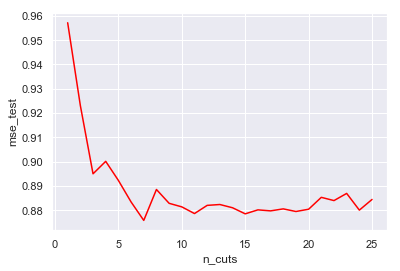

In [69]:
bin_reg_df = pd.DataFrame(bin_reg)
sns.lineplot(x=bin_reg_df['n_cuts'], y=bin_reg_df['mse_test'], color='red')

In [14]:
bin_reg_df.loc[bin_reg_df['mse_test'].idxmin(), :]

n_cuts      7.000000
mse_test    0.875825
Name: 6, dtype: float64

In [27]:
X_train, X_test, y_train, y_test = train_test_split(X.values.reshape(-1,1), y, test_size=0.33, random_state=42)
binner = Binner(X.min(), X.max(), n_cuts=7)
linreg = LinearRegression(fit_intercept=False).fit(binner.fit_transform(X_train), y_train)
np.sqrt(mean_squared_error(y_test, linreg.predict(binner.fit_transform(X_test))))

39.24772730694755

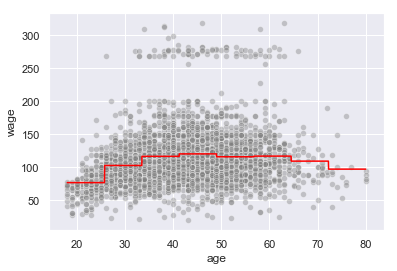

In [68]:
t = np.linspace(X.min(), X.max(), 3000)
y_pred = linreg.predict(binner.fit_transform(t.reshape(-1,1)))

sns.lineplot(t, y_pred, color='red')
sns.scatterplot(X, y, color='grey', alpha=0.4)